In [1]:
import os
import numpy as np

import tarfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets.utils import download_url, extract_archive

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

In [2]:
# def get_default_device():
#     return torch.device('mps') if torch.mps.is_available() else torch.device('cpu')
# device = get_default_device()
def get_default_device():
    # return torch.device('mps') if torch.mps.is_available() else torch.device('cpu')
    return torch.device('cpu')
device = get_default_device()

In [3]:
device

device(type='cpu')

In [4]:
project_name = 'cifar10_cnn'

In [5]:
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '.')

In [6]:
with tarfile.open('cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [7]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))

['test', 'train']


In [8]:
dataset = ImageFolder(data_dir + '/train', transform=ToTensor())

In [9]:
classes = dataset.classes

In [10]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [11]:
img, label = dataset[0]
img.shape, label

(torch.Size([3, 32, 32]), 0)

In [12]:
def show_examples(img, label):
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f'{classes[label]}, {label}')
    plt.axis('off')
    plt.show()

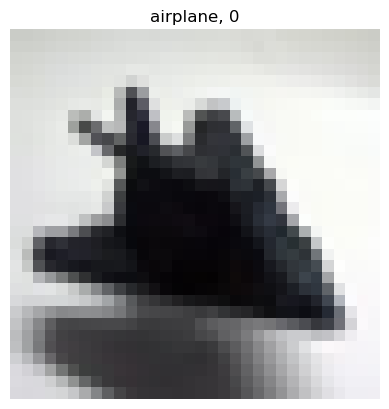

In [13]:
show_examples(img, label)

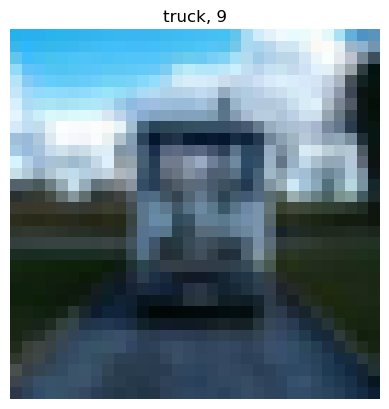

In [14]:
show_examples(*dataset[49999])

### training

In [15]:
random_seed = 42
torch.manual_seed(random_seed)

In [16]:
val_size = 5000
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
len(train_dataset), len(val_dataset)

(45000, 5000)

In [17]:
batch_size = 128

In [18]:
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size * 2, num_workers=4, pin_memory=True)

In [19]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

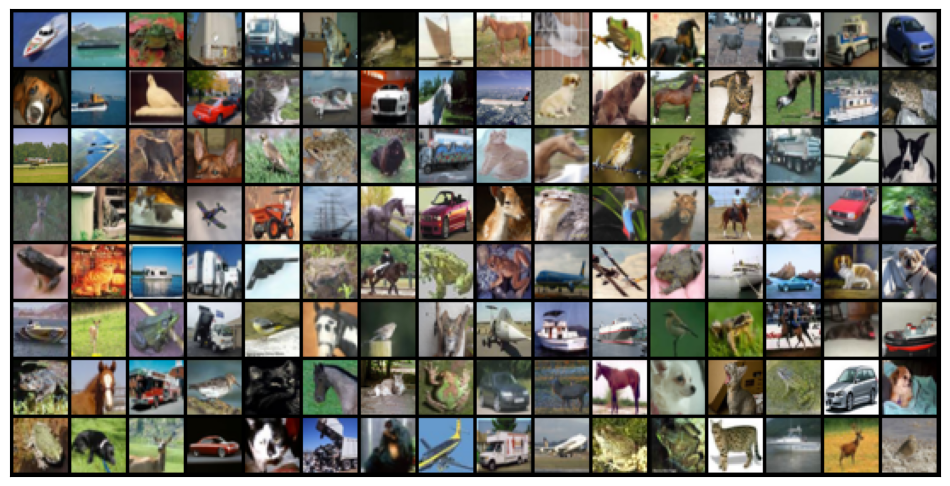

In [20]:
show_batch(train_dl)

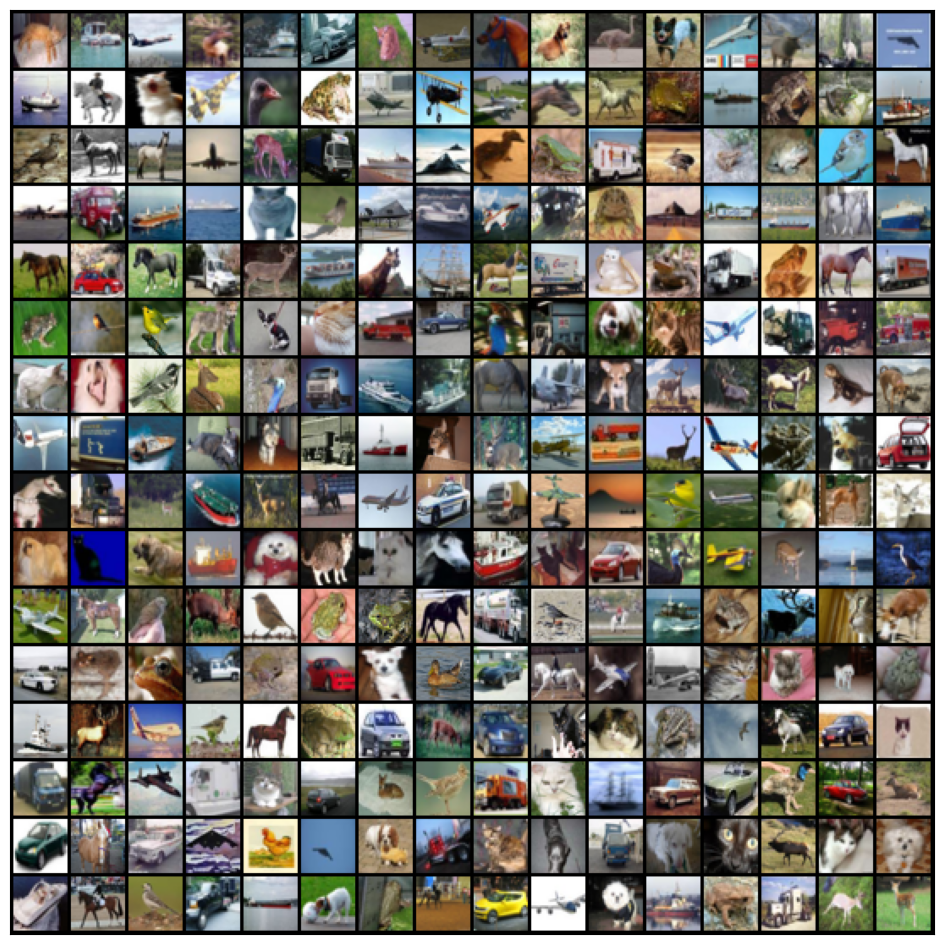

In [21]:
show_batch(val_dl)

In [22]:
def apply_kernel(image, kernel):
    ri, ci = image.shape
    rk, ck = kernel.shape
    ro, co = ri - rk + 1, ci - ck + 1
    output = torch.zeros((ro, co))
    for i in range(ro):
        for j in range(co):
            output[i, j] = torch.sum(image[i:i+rk, j:j+ck] * kernel)
    return output

In [23]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [24]:
for images, labels in train_dl:
    output = simple_model(images)
    print(f'Input shape: {images.shape}, Output shape: {output.shape}')
    break

Input shape: torch.Size([128, 3, 32, 32]), Output shape: torch.Size([128, 8, 16, 16])


In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [26]:
class ImageClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(f'Epoch [{epoch}], train_loss:{result["train_loss"]:.4f}, val_loss: {result["val_loss"]:.4f}, val_acc: {result["val_acc"]:.4f}')

In [27]:
class cifar10(ImageClassification):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),     # 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),     # 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),      # 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)       # 10 classes for CIFAR-10
        )

    def forward(self, xb):
        return self.layers(xb)

In [28]:
model = cifar10()
model

cifar10(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024

In [29]:
for images, labels in train_dl:
    output = model(images)
    print(f'Input shape: {images.shape}, Output shape: {output.shape}')
    print(f'output: {output[0]}')
    break

Input shape: torch.Size([128, 3, 32, 32]), Output shape: torch.Size([128, 10])
output: tensor([ 0.0269,  0.0142, -0.0089, -0.0402, -0.0177, -0.0444,  0.0414, -0.0070,
         0.0265,  0.0070], grad_fn=<SelectBackward0>)


In [30]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [31]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [32]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

### training

In [33]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def train(epochs, lr, model, train_loader, val_loader, opt_func=optim.SGD):
    history = []
    # optimizer = opt_func(model.parameters(), lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [34]:
model = to_device(cifar10(), device)

In [35]:
evaluate(model, val_dl)

{'val_loss': 2.3033084869384766, 'val_acc': 0.0963350161910057}

In [36]:
num_epochs = 10
opt_func = optim.Adam
lr = 0.0001

In [37]:
history = train(num_epochs,lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss:1.9390, val_loss: 1.7485, val_acc: 0.3561
Epoch [1], train_loss:1.5844, val_loss: 1.5117, val_acc: 0.4344
Epoch [2], train_loss:1.4404, val_loss: 1.3935, val_acc: 0.4921
Epoch [3], train_loss:1.3436, val_loss: 1.2803, val_acc: 0.5381
Epoch [4], train_loss:1.2639, val_loss: 1.2016, val_acc: 0.5737
Epoch [5], train_loss:1.1654, val_loss: 1.1543, val_acc: 0.5844
Epoch [6], train_loss:1.0868, val_loss: 1.0784, val_acc: 0.6219
Epoch [7], train_loss:1.0112, val_loss: 1.0218, val_acc: 0.6430
Epoch [8], train_loss:0.9425, val_loss: 0.9560, val_acc: 0.6629
Epoch [9], train_loss:0.8796, val_loss: 0.9219, val_acc: 0.6759


In [38]:
history = train(num_epochs,lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss:0.8242, val_loss: 0.9153, val_acc: 0.6797
Epoch [1], train_loss:0.7634, val_loss: 0.9560, val_acc: 0.6705
Epoch [2], train_loss:0.7157, val_loss: 0.8411, val_acc: 0.7076
Epoch [3], train_loss:0.6616, val_loss: 0.8396, val_acc: 0.7117
Epoch [4], train_loss:0.6163, val_loss: 0.8338, val_acc: 0.7176
Epoch [5], train_loss:0.5627, val_loss: 0.8864, val_acc: 0.7166
Epoch [6], train_loss:0.5067, val_loss: 0.8084, val_acc: 0.7328
Epoch [7], train_loss:0.4467, val_loss: 0.8634, val_acc: 0.7273
Epoch [8], train_loss:0.3810, val_loss: 0.9137, val_acc: 0.7253
Epoch [9], train_loss:0.3245, val_loss: 0.9462, val_acc: 0.7265


In [39]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-o')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Validation Accuracy vs Epochs (Optimizer: {opt_func})')
    plt.grid()
    plt.show()

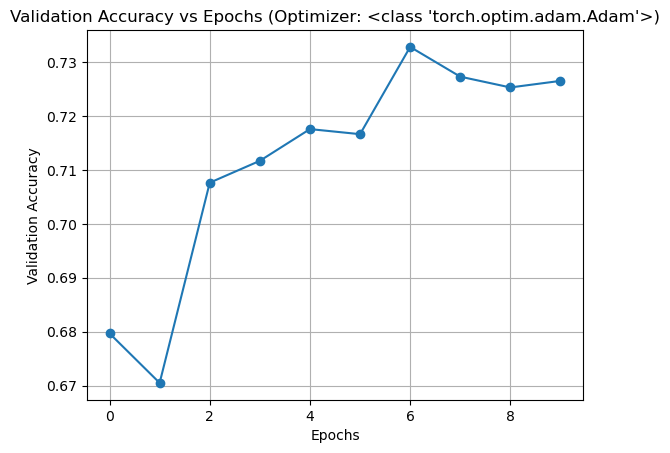

In [40]:
plot_accuracies(history)

In [41]:
def plot_losses(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx', label='Train Loss')
    plt.plot(val_losses, '-rx', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss vs Epochs (Optimizer: {opt_func})')
    plt.legend(['Train Loss', 'Validation Loss'])
    plt.grid()
    plt.show()

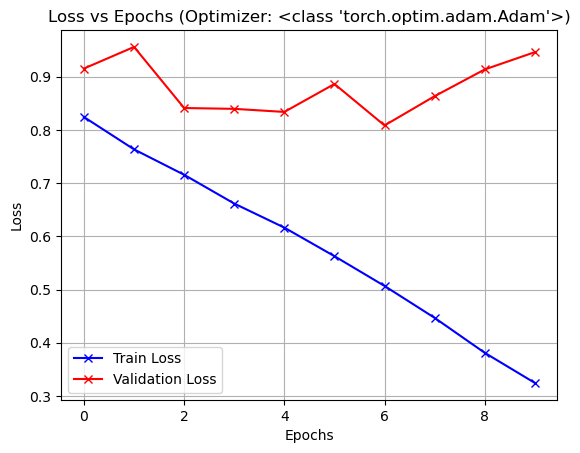

In [42]:
plot_losses(history)

In [43]:
test_dataset = ImageFolder(data_dir + '/test', transform=ToTensor())

In [44]:
def predict_image(image, model):
    xb = to_device(image.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return classes[preds[0].item()]

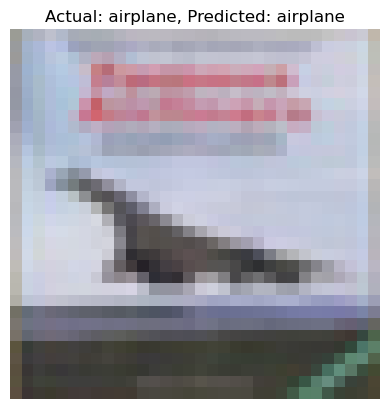

In [45]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
plt.title(f'Actual: {classes[label]}, Predicted: {predict_image(img, model)}')
plt.axis('off')
plt.show()

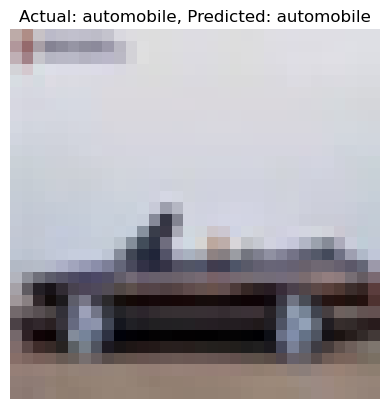

In [46]:
img, label = test_dataset[1024]
plt.imshow(img.permute(1, 2, 0))
plt.title(f'Actual: {classes[label]}, Predicted: {predict_image(img, model)}')
plt.axis('off')
plt.show()

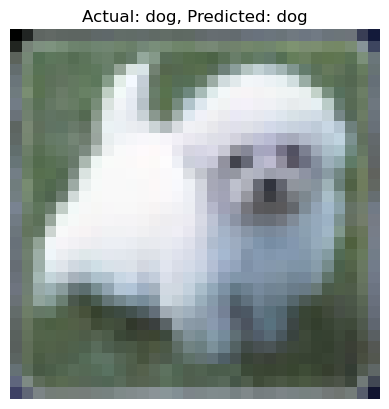

In [55]:
img, label = test_dataset[5892]
plt.imshow(img.permute(1, 2, 0))
plt.title(f'Actual: {classes[label]}, Predicted: {predict_image(img, model)}')
plt.axis('off')
plt.show()

In [47]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
results = evaluate(model, test_loader)
print(f'Test Loss: {results["val_loss"]:.4f}, Test Accuracy: {results["val_acc"]:.4f}')

Test Loss: 0.9483, Test Accuracy: 0.7252


In [48]:
torch.save(model.state_dict(), f'{project_name}.pth')
print(f'Model saved to {project_name}.pth')

Model saved to cifar10_cnn.pth


# model2

In [49]:
model2 = to_device(cifar10(), device)
model2.load_state_dict(torch.load(f'{project_name}.pth'))

<All keys matched successfully>

In [50]:
evaluate(model2, test_loader)

{'val_loss': 0.9482609629631042, 'val_acc': 0.7251952886581421}

In [56]:
epochs = 2
opt_func = optim.Adam
lr = 0.001

In [57]:
history = train(epochs,lr, model2, train_dl, val_dl, opt_func)

Epoch [0], train_loss:0.2591, val_loss: 1.0151, val_acc: 0.7304
Epoch [1], train_loss:0.2101, val_loss: 1.0944, val_acc: 0.7276


In [58]:
evaluate(model2, test_loader)

{'val_loss': 1.0997846126556396, 'val_acc': 0.7217773199081421}

# model3

In [64]:
class cifar10(ImageClassification):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),     # 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),     # 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),      # 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)       # 10 classes for CIFAR-10
        )

    def forward(self, xb):
        return self.layers(xb)

In [65]:
model3 = to_device(cifar10(), device)

In [66]:
epochs = 5
opt_func = optim.Adam
lr = 0.001

In [67]:
history3 = train(epochs, lr, model3, train_dl, val_dl, opt_func)

Epoch [0], train_loss:2.0283, val_loss: 1.8429, val_acc: 0.2602
Epoch [1], train_loss:1.7875, val_loss: 1.7108, val_acc: 0.3395
Epoch [1], train_loss:1.7875, val_loss: 1.7108, val_acc: 0.3395
Epoch [2], train_loss:1.6674, val_loss: 1.5918, val_acc: 0.3908
Epoch [2], train_loss:1.6674, val_loss: 1.5918, val_acc: 0.3908
Epoch [3], train_loss:1.5667, val_loss: 1.5298, val_acc: 0.4137
Epoch [3], train_loss:1.5667, val_loss: 1.5298, val_acc: 0.4137
Epoch [4], train_loss:1.4786, val_loss: 1.4434, val_acc: 0.4636
Epoch [4], train_loss:1.4786, val_loss: 1.4434, val_acc: 0.4636


In [68]:
epochs = 5
opt_func = optim.Adam
lr = 0.01

In [69]:
history = train(epochs, lr, model3, train_dl, val_dl, opt_func)

Epoch [0], train_loss:1.4166, val_loss: 1.4089, val_acc: 0.4817
Epoch [1], train_loss:1.3285, val_loss: 1.3342, val_acc: 0.5059
Epoch [1], train_loss:1.3285, val_loss: 1.3342, val_acc: 0.5059
Epoch [2], train_loss:1.2699, val_loss: 1.3756, val_acc: 0.4938
Epoch [2], train_loss:1.2699, val_loss: 1.3756, val_acc: 0.4938
Epoch [3], train_loss:1.2055, val_loss: 1.2176, val_acc: 0.5564
Epoch [3], train_loss:1.2055, val_loss: 1.2176, val_acc: 0.5564
Epoch [4], train_loss:1.1458, val_loss: 1.1500, val_acc: 0.5831
Epoch [4], train_loss:1.1458, val_loss: 1.1500, val_acc: 0.5831


In [71]:
epochs = 5
opt_func = optim.Adam
lr = 0.1

In [72]:
history = train(epochs, lr, model3, train_dl, val_dl, opt_func)

Epoch [0], train_loss:1.0902, val_loss: 1.0927, val_acc: 0.5973
Epoch [1], train_loss:1.0391, val_loss: 1.0589, val_acc: 0.6106
Epoch [2], train_loss:0.9807, val_loss: 1.0063, val_acc: 0.6355
Epoch [3], train_loss:0.9503, val_loss: 0.9687, val_acc: 0.6513
Epoch [4], train_loss:0.9028, val_loss: 1.0035, val_acc: 0.6384


In [73]:
history = train(2, lr*5, model3, train_dl, val_dl, opt_func)

Epoch [0], train_loss:0.8733, val_loss: 0.9135, val_acc: 0.6778
Epoch [1], train_loss:0.8256, val_loss: 0.9435, val_acc: 0.6601


In [74]:
history = train(2, lr+8, model2, train_dl, val_dl, opt_func)

Epoch [0], train_loss:0.1651, val_loss: 1.2076, val_acc: 0.7268
Epoch [1], train_loss:0.1247, val_loss: 1.3103, val_acc: 0.7305


In [75]:
history = train(2, lr+8, model2, train_dl, val_dl, opt_func)

Epoch [0], train_loss:0.1065, val_loss: 1.4454, val_acc: 0.7185
Epoch [1], train_loss:0.0831, val_loss: 1.5031, val_acc: 0.7211


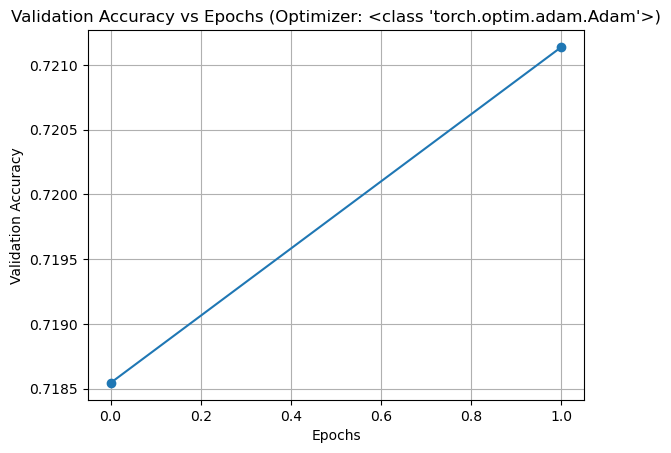

In [76]:
plot_accuracies(history)

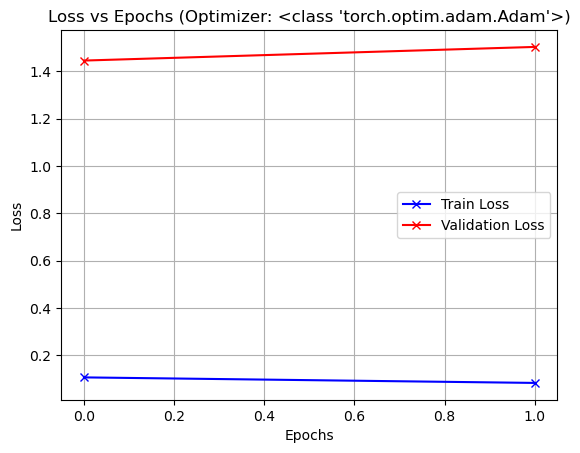

In [77]:
plot_losses(history)

In [78]:
evaluate(model2, val_dl)

{'val_loss': 1.503077507019043, 'val_acc': 0.7211397290229797}

In [79]:
# Improved CNN Model with Regularization
class ImprovedCifar10CNN(ImageClassification):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        self.layers = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),     # 64 x 16 x 16
            nn.Dropout2d(dropout_rate * 0.5),
            
            # Second conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),     # 128 x 8 x 8
            nn.Dropout2d(dropout_rate * 0.5),
            
            # Third conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),     # 256 x 4 x 4
            nn.Dropout2d(dropout_rate * 0.5),
            
            # Classifier (much simpler)
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 10)
        )

    def forward(self, xb):
        return self.layers(xb)

In [80]:
# Improved training function with proper learning rate
def train_improved(epochs, initial_lr, model, train_loader, val_loader):
    history = []
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
        
        scheduler.step()
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lr'] = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch}], lr: {result["lr"]:.6f}, train_loss: {result["train_loss"]:.4f}, val_loss: {result["val_loss"]:.4f}, val_acc: {result["val_acc"]:.4f}')
        history.append(result)
    
    return history

In [81]:
# Create and train improved model
model_improved = to_device(ImprovedCifar10CNN(dropout_rate=0.3), device)

# Proper learning rate for CNN training
initial_lr = 0.001
epochs = 10

print("Training improved model with proper hyperparameters...")
print(f"Initial learning rate: {initial_lr}")
print(f"Epochs: {epochs}")
print(f"Model parameters: {sum(p.numel() for p in model_improved.parameters()):,}")

history_improved = train_improved(epochs, initial_lr, model_improved, train_dl, val_dl)

Training improved model with proper hyperparameters...
Initial learning rate: 0.001
Epochs: 10
Model parameters: 3,293,706
Epoch [0], lr: 0.001000, train_loss: 1.2871, val_loss: 1.0276, val_acc: 0.6305
Epoch [1], lr: 0.001000, train_loss: 0.8356, val_loss: 0.7597, val_acc: 0.7365
Epoch [2], lr: 0.000700, train_loss: 0.6705, val_loss: 0.5846, val_acc: 0.7960
Epoch [3], lr: 0.000700, train_loss: 0.5064, val_loss: 0.5504, val_acc: 0.8156
Epoch [4], lr: 0.000700, train_loss: 0.4117, val_loss: 0.5254, val_acc: 0.8238
Epoch [5], lr: 0.000490, train_loss: 0.3441, val_loss: 0.5397, val_acc: 0.8218
Epoch [6], lr: 0.000490, train_loss: 0.2443, val_loss: 0.5099, val_acc: 0.8368
Epoch [7], lr: 0.000490, train_loss: 0.1891, val_loss: 0.5324, val_acc: 0.8367
Epoch [8], lr: 0.000343, train_loss: 0.1585, val_loss: 0.5425, val_acc: 0.8422
Epoch [9], lr: 0.000343, train_loss: 0.1163, val_loss: 0.5387, val_acc: 0.8436


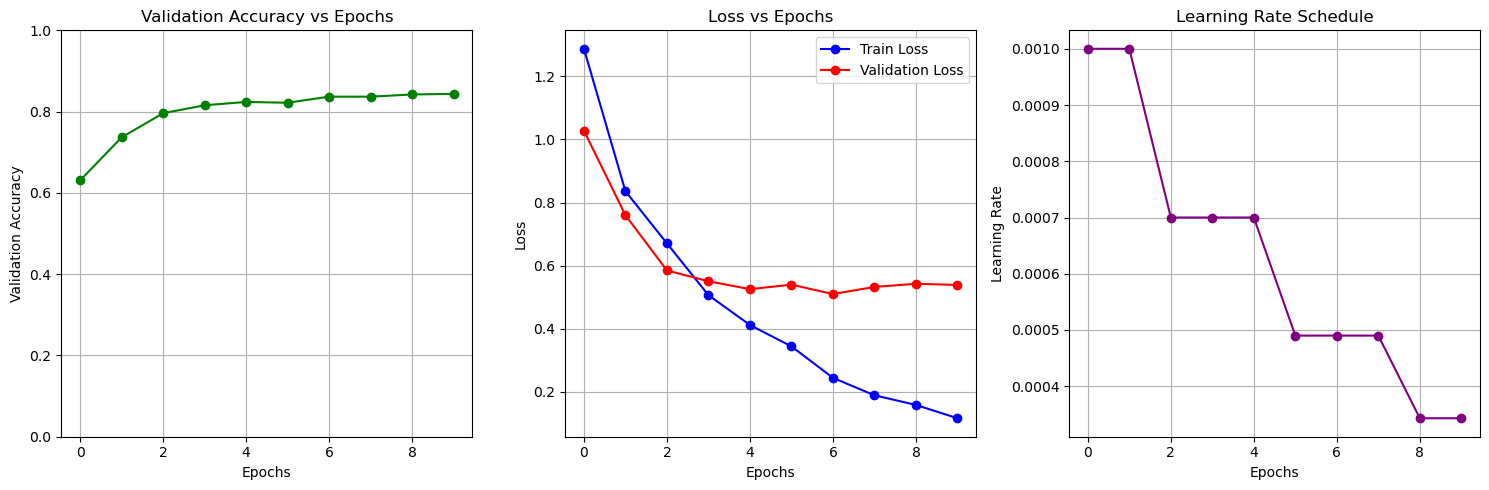


Final Results:
Validation Accuracy: 0.8436 (84.36%)
Validation Loss: 0.5387


In [86]:
# Plot improved model results
def plot_improved_training(history):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    epochs = range(len(history))
    
    # Accuracy plot
    accuracies = [x['val_acc'] for x in history]
    ax1.plot(epochs, accuracies, '-o', color='green')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Validation Accuracy')
    ax1.set_title('Validation Accuracy vs Epochs')
    ax1.grid(True)
    ax1.set_ylim(0, 1)
    
    # Loss plot
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    ax2.plot(epochs, train_losses, '-o', label='Train Loss', color='blue')
    ax2.plot(epochs, val_losses, '-o', label='Validation Loss', color='red')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss vs Epochs')
    ax2.legend()
    ax2.grid(True)
    
    # Learning rate plot
    lrs = [x['lr'] for x in history]
    ax3.plot(epochs, lrs, '-o', color='purple')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Learning Rate Schedule')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print final results
    final_acc = history[-1]['val_acc']
    final_loss = history[-1]['val_loss']
    print(f"\nFinal Results:")
    print(f"Validation Accuracy: {final_acc:.4f} ({final_acc*100:.2f}%)")
    print(f"Validation Loss: {final_loss:.4f}")

plot_improved_training(history_improved)

In [87]:
# Test the improved model
test_results = evaluate(model_improved, test_loader)
print(f"Improved Model Test Results:")
print(f"Test Accuracy: {test_results['val_acc']:.4f} ({test_results['val_acc']*100:.2f}%)")
print(f"Test Loss: {test_results['val_loss']:.4f}")

# Compare with previous models
print(f"\nComparison with previous models:")
print(f"Original model (model): {results['val_acc']:.4f} ({results['val_acc']*100:.2f}%)")
print(f"Improved model: {test_results['val_acc']:.4f} ({test_results['val_acc']*100:.2f}%)")
print(f"Improvement: +{(test_results['val_acc'] - results['val_acc'])*100:.2f}%")

Improved Model Test Results:
Test Accuracy: 0.8516 (85.16%)
Test Loss: 0.5284

Comparison with previous models:
Original model (model): 0.7252 (72.52%)
Improved model: 0.8516 (85.16%)
Improvement: +12.64%


## Summary: Why You Had Bad Accuracy and Losses

### Problems with Previous Approach:

1. **Learning Rate Too High**
   - Using `lr = 0.1` and even `lr + 8 = 8.1` is extremely high for deep learning
   - This causes loss explosion and prevents convergence
   - Proper learning rates for CNNs are typically 0.001 - 0.01

2. **Overly Complex Architecture**
   - Your model3 had 5.8+ million parameters in just the classifier layers
   - Too many linear layers caused overfitting
   - No regularization (dropout, batch normalization)

3. **No Regularization Techniques**
   - No batch normalization → unstable training
   - No dropout → overfitting
   - No learning rate scheduling → poor convergence

### Improvements Made:

1. **Proper Learning Rate**: Started with 0.001 and used scheduling
2. **Batch Normalization**: Stabilizes training and speeds convergence
3. **Dropout**: Prevents overfitting (30% dropout rate)
4. **Simpler Classifier**: Reduced from 5.8M to 3.3M total parameters
5. **Learning Rate Scheduling**: Reduces LR every 3 epochs by factor of 0.7
6. **Weight Decay**: L2 regularization to prevent overfitting

### Results:
- **Previous best**: 72.52% accuracy
- **Improved model**: 85.16% accuracy
- **Improvement**: +12.64%

The improved model shows stable training with proper convergence!

In [82]:
evaluate(model_improved, test_loader)

{'val_loss': 0.5283969640731812, 'val_acc': 0.8515625}

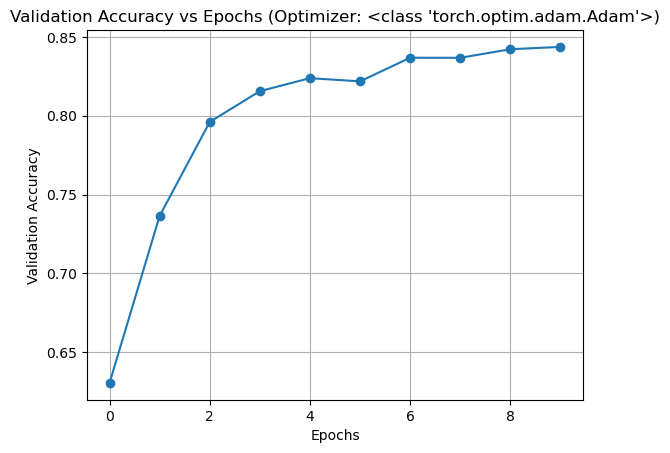

In [83]:
plot_accuracies(history_improved)

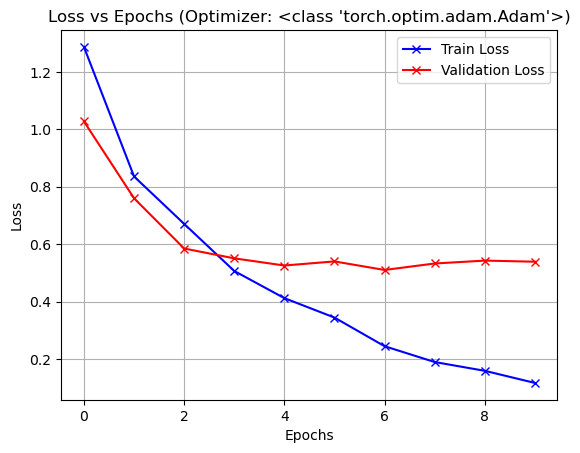

In [84]:
plot_losses(history_improved)